Tutorial Followed:

https://snawarhussain.com/blog/computer%20vision/python/tutorial/photometric-stereo-lambertian-model/

Loading dataset and normalizing it with the intensity values

In [63]:
import random
import cv2
import glob
import os
import numpy as np
import re
import yaml
import matplotlib.pyplot as plt

Helper Functions

In [64]:
def numerical_sort(value):
    """
    Helper function to sort files numerically by their filenames.
    """
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def load_light_matrix(yaml_file):
    """
    Loads the LightMatrix.yml file using OpenCV's FileStorage.
    """
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    light_matrix = fs.getNode("Lights").mat()
    fs.release()
    return light_matrix

Photometric Stereo Function

In [65]:
def PMS(imgs, L_list):
    """
    This is the main function for performing photometric stereo using three images.

        Parameters
        ----------
        imgs: np.ndarray
            ndarray of all the images of an object taken with different light sources
        L_list: list
            the list of the light sources directions S for each image. for each image the S is a vector matrix with 3  positional elements (x,y,z)
        return:
            returns the computed albedos and the surface normals of the object
    """

    L = np.array(L_list) # note that light vector is passed as a list.
    Lt = L.T # taking transpose.
    h, w = imgs[0].shape[:2] # note that images are passed as an ndarray.

    img_normal = np.zeros((h, w, 3)) 
    img_albedo = np.zeros((h, w, 3))
    I = np.zeros((len(L_list), 3)) # Image intensity.

    for x in range(w): # iterate through all rows.
        for y in range(h): # iterate through all columns.
            for i in range(len(imgs)): # iterate through all images.
                I[i] = imgs[i][y][x] # getting intensities for the 3 images to construct the Intensity vecotr

            tmp1 = np.linalg.inv(Lt @ L) @ Lt

            N = np.dot(tmp1, I).T # based on the equation N = inv(S)*I, where S is the source matrix (includes all vectors)
            rho = np.linalg.norm(N, axis=1) # calculate albedo, axis = 1 calculates for every row, i.e for each normal vector in the array N.
            # specifically done for row because in N matrix, each row represents a point in 3D space. So each row needs to be treated as an independent vector.
            # if axis is not set then norm computes euclidean norm for the whole matrix as if it was a single flattened vector, this will yield a single scalarvalue.
            # is axis = 0, then euclidean norm will be computed column wise.
            img_albedo[y][x] = rho

            # Create a weighted projection of the normal vector into a gray-scale value. Just for representation.
            N_gray = N[0]*0.0722 + N[1]*0.7152 + N[2]*0.2126  # luminosity formula (PS: x, y, z weighed to Gray), i.e borrowed from RGB color space but not a color space conversion here.
            Nnorm = np.linalg.norm(N)
            if Nnorm==0: # finding degenerate cases, invalid dark pixels with no light.
                continue 
            img_normal[y][x] = N_gray/Nnorm # normalize the Ngray derived above.

    img_normal_rgb = ((img_normal*0.5 + 0.5)*255).astype(np.uint8)  # (x y z) cooridinate to RGB coordinate converstion. Equation in the tutorial.
    img_normal_rgb = cv2.cvtColor(img_normal_rgb, cv2.COLOR_BGR2RGB)  # converting from BGR to RGB for correct visualization. cv2 uses BGR format.
    img_albedo = (img_albedo/np.max(img_albedo)*255).astype(np.uint8)
    return img_normal, img_albedo, img_normal_rgb

Sample 3 images randomly from data for constructing surface normals and albedo

In [66]:
# Dataset processing
root_folder = "D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/buddha12/buddha12"  # Replace with the actual path to the 'samples' folder

# Initialize storage for visualization
images, img_albedo, img_normal_rgb = None, None, None

print(f"Processing root folder: {root_folder}")

# Load light directions from YAML
# Corrected YAML file loader
yaml_path = os.path.join(root_folder, "LightMatrix.yml")  # Ensure the file extension is correct
if not os.path.exists(yaml_path):
    print(f"LightMatrix.yml not found in {root_folder}. Exiting.")
    exit()
light_directions = load_light_matrix(yaml_path)

# Filter images, excluding 'mask.bmp' and 'all.bmp'
img_names = [f for f in glob.glob(os.path.join(root_folder, "*.bmp")) if not (f.endswith("mask.bmp") or f.endswith("all.bmp"))]
img_names = sorted(img_names, key=numerical_sort)[:3]  # Pick at most 3 images

print(img_names)

if len(img_names) < 3:
    print(f"Not enough valid images found in {root_folder}. Found {len(img_names)} valid images. Exiting.")
    exit()

# Load images
images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in img_names]
images = np.array(images)

# Load mask
mask_path = os.path.join(root_folder, "mask.bmp")
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    print(f"Mask file not found in {root_folder}. Exiting.")
    exit()

# Apply mask to images
for i in range(len(images)):
    images[i] = cv2.bitwise_and(images[i], images[i], mask=mask)

print(f"Loaded {len(images)} valid images and light directions from the root folder.")

# Run Photometric Stereo
img_normal, img_albedo, img_normal_rgb = PMS(images, light_directions)

Processing root folder: D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/buddha12/buddha12
['D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/buddha12/buddha12\\buddha.0.bmp', 'D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/buddha12/buddha12\\buddha.1.bmp', 'D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/buddha12/buddha12\\buddha.2.bmp']
Loaded 3 valid images and light directions from the root folder.


Plotting

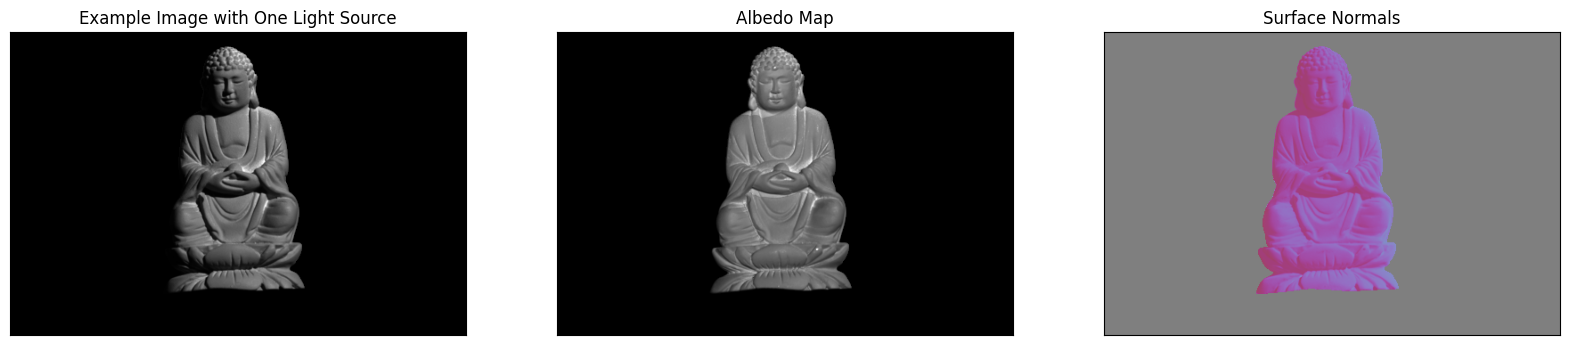

In [70]:
# Display results
if images is not None and img_albedo is not None and img_normal_rgb is not None:
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0], cmap='gray')
    plt.title("Example Image with One Light Source")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, 2)
    plt.imshow(img_albedo, cmap='gray')
    plt.title("Albedo Map")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, 3)
    plt.imshow(img_normal_rgb)
    plt.title("Surface Normals")
    plt.xticks([])
    plt.yticks([])

    plt.show()
else:
    print("No valid data to display.")

Using all Images

In [68]:
def PMS_all(imgss, L_list):
    """
    Perform photometric stereo using all valid images.

    Parameters
    ----------
    imgss: np.ndarray
        ndarray of all the images of an object taken with different light sources
    L_list: list
        List of light source directions. Each element is a vector with 3 positional elements (x, y, z).
        
    Returns:
        img_normal: Surface normals map
        img_albedo: Albedo map
        img_normal_rgb: Surface normals in RGB colorspace for visualization
    """

    # Ensure the number of images matches the number of light directions
    num_lights = len(L_list)
    imgss = imgss[:num_lights]

    L = np.array(L_list)  # Light source matrix
    Lt = L.T  # Transpose of the light matrix
    h, w = imgss[0].shape[:2]  # Image dimensions

    img_normal = np.zeros((h, w, 3), dtype=np.float32)  # Initialize surface normals
    img_albedo = np.zeros((h, w), dtype=np.float32)  # Initialize albedo map
    I = np.zeros(num_lights, dtype=np.float32)  # Initialize intensity vector

    for y in range(h):  # Iterate over rows
        for x in range(w):  # Iterate over columns
            for i in range(num_lights):  # Collect intensities for each light source
                I[i] = imgss[i][y, x]

            # Solve for normal and albedo using least squares
            tmp1 = np.linalg.pinv(Lt @ L)  # Use pseudo-inverse for numerical stability
            tmp2 = Lt @ I
            N = np.dot(tmp1, tmp2)  # Normal vector

            # Compute albedo
            rho = np.linalg.norm(N)  # Albedo (magnitude of normal)
            if rho > 0:
                img_albedo[y, x] = rho
                img_normal[y, x] = N / rho  # Normalize the normal vector
            else:
                img_normal[y, x] = [0, 0, 0]

    # Convert surface normals to RGB
    img_normal_rgb = ((img_normal * 0.5) + 0.5) * 255  # Normalize to [0, 255] for visualization
    img_normal_rgb = img_normal_rgb.astype(np.uint8)
    img_normal_rgb = cv2.cvtColor(img_normal_rgb, cv2.COLOR_BGR2RGB)

    # Scale albedo for visualization
    img_albedo = (img_albedo / np.max(img_albedo) * 255).astype(np.uint8)

    return img_normal, img_albedo, img_normal_rgb


In [71]:
# Dataset processing
root_folder = "D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/ball3/ball3"  # Replace with the actual path to the 'samples' folder

# Initialize storage for visualization
images, img_albedo, img_normal_rgb = None, None, None

print(f"Processing root folder: {root_folder}")

# Load light directions from YAML
# Corrected YAML file loader
yaml_path = os.path.join(root_folder, "LightMatrix.yml")  # Ensure the file extension is correct
if not os.path.exists(yaml_path):
    print(f"LightMatrix.yml not found in {root_folder}. Exiting.")
    exit()
light_directions = load_light_matrix(yaml_path)

# Filter images, excluding 'mask.bmp' and 'all.bmp'
img_names = [f for f in glob.glob(os.path.join(root_folder, "*.bmp")) if not (f.endswith("mask.bmp") or f.endswith("all.bmp"))]
img_names = sorted(img_names, key=numerical_sort)[:]  # Pick all images

print(img_names)

if len(img_names) < 3:
    print(f"Not enough valid images found in {root_folder}. Found {len(img_names)} valid images. Exiting.")
    exit()

# Load images
images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in img_names]
images = np.array(images)

# Load mask
mask_path = os.path.join(root_folder, "mask.bmp")
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    print(f"Mask file not found in {root_folder}. Exiting.")
    exit()

# Apply mask to images
for i in range(len(images)):
    images[i] = cv2.bitwise_and(images[i], images[i], mask=mask)

print(f"Loaded {len(images)} valid images and light directions from the root folder.")

# Run Photometric Stereo
img_normal, img_albedo, img_normal_rgb = PMS_all(images, light_directions)

Processing root folder: D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/ball3/ball3
['D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/ball3/ball3\\ball0.bmp', 'D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/ball3/ball3\\ball1.bmp', 'D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/ball3/ball3\\ball2.bmp', 'D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/ball3/ball3\\ball3.bmp', 'D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/ball3/ball3\\ball4.bmp', 'D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/ball3/ball3\\ball5.bmp', 'D:/Onedrive/experiments/experiments/3d_reconstruction/photometric_stereo/example_work/samples/ball3/ball3\\ball6.bmp', 'D:/Onedrive/experiments/expe

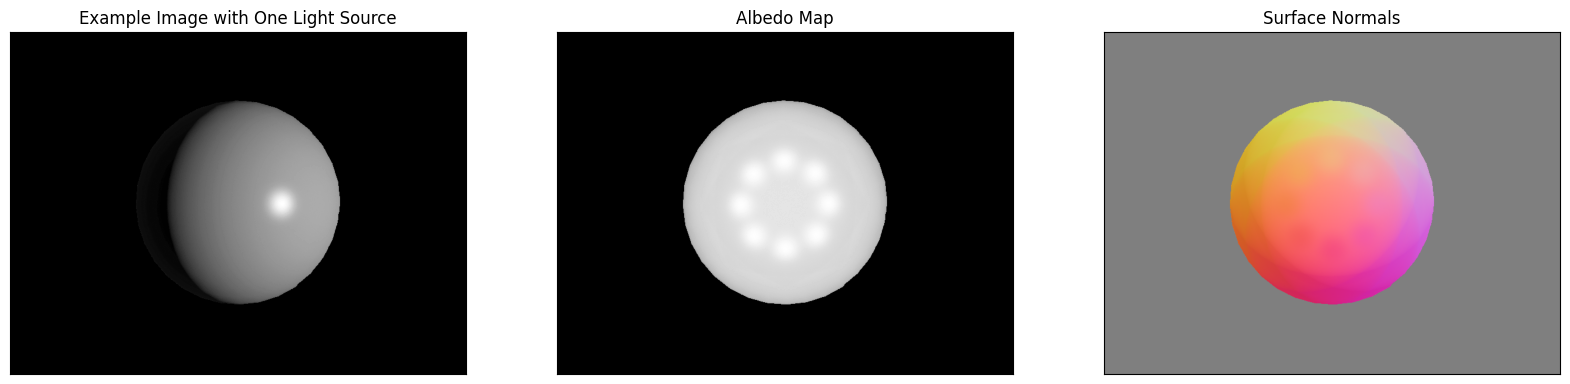

In [72]:
# Display results
if images is not None and img_albedo is not None and img_normal_rgb is not None:
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0], cmap='gray')
    plt.title("Example Image with One Light Source")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, 2)
    plt.imshow(img_albedo, cmap='gray')
    plt.title("Albedo Map")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, 3)
    plt.imshow(img_normal_rgb)
    plt.title("Surface Normals")
    plt.xticks([])
    plt.yticks([])

    plt.show()
else:
    print("No valid data to display.")